# Pytorch dataset creation

> pytorch dataset will be created here

In [ ]:
#| default_exp dataloader_creation

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from PIL import Image
from typing import List, Callable, Tuple, Dict, Union
from pathlib import Path
from fastcore.all import *
import cv2
import torch
from fastcore.all import *
from fastcore.foundation import *


import matplotlib.pyplot as plt
import numpy as np
from typing import Optional
from scipy import ndimage

In [ ]:
#| export
from cv_tools.core import *
from cv_tools.imports import *
from fastcore.all import *
from fastcore.imports import *
from fastcore.script import *

In [ ]:
#| export
def get_transforms(*, data):
    if data == 'train':
        return A.Compose([
            #A.Resize(256, 256),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Transpose(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
            #A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            A.Normalize(mean=[0, 0, 0], std=[1/255, 1/255, 1/255]),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            #A.Resize(256, 256),
            A.Normalize(mean=[0, 0, 0], std=[1/255, 1/255, 1/255]),
            #A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

In [ ]:
from fastcore.all import *
from cv_tools.core import *

In [ ]:
#| export
class SegmentationDataset(Dataset):
    def __init__(self, image_path, mask_path, exts, transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.exts = exts
        self.images = Path(image_path).ls(file_exts=exts)
        self.masks = Path(mask_path).ls(file_exts=exts)
        self.transform = transform

        super().__init__()
        store_attr()
        __repr__ = basic_repr()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        name_ = Path(img_path).name
        msk_path = Path(self.mask_path, name_)
        image = np.array(Image.open(img_path).convert('L'), dtype=np.float32) / 255.0 # convert to grayscale
        mask = np.array(Image.open(msk_path).convert('L'), dtype=np.float32) / 255.0


        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        mask = np.where(mask > 0.5, 1.0, 0.0)
        mask = mask[None, ...]

        return image, mask# Add channel dimension to mask

In [ ]:
Path.cwd()

Path('/home/hasan/Schreibtisch/projects/git_data/segmentation_test/nbs')

In [ ]:

root_path= Path(r'm:/data/projects/easy_front_detection/eberhard_data')
im_path = f'{root_path}/images'
mask_path = f'{root_path}/masks'
DATA_PATH = Path(os.getenv('DATA_PATH'), 'regensburg_xray')
IMAGE_PATH = Path(DATA_PATH, 'trn_images_632')
MASK_PATH = Path(DATA_PATH, 'trn_masks_632')


In [ ]:
TRAIN_SPLIT=0.8

In [ ]:
train_len = int(TRAIN_SPLIT *len(dataset))
val_len = len(dataset) - train_len
train_len, val_len

(271, 68)

In [ ]:
train_dataset, val_dataset = random_split(
    dataset,
    lengths=[train_len, val_len]
)

In [ ]:
len(train_dataset), len(val_dataset)

(271, 68)

In [ ]:
#| export
def repeat_collate_fn(batch, batch_size=4):
    images, masks = zip(*batch)

    images = list(images)
    masks = list(masks)

    num_to_add = batch_size - len(images)
    if num_to_add > 0:
        for i in range(num_to_add):
            index = i%len(images)
            images.append(images[index])
            masks.append(masks[index])
    return torch.stack(images), torch.stack(masks)


In [ ]:
#| export
def split_ds(ds:Dataset, val_split:float=0.2):
    val_len = int(len(ds) * val_split)
    trn_ds = Subset(ds, indices=range(val_len))
    val_ds = Subset(ds, indices=range(val_len, len(ds)))
    return trn_ds, val_ds


In [ ]:
#| export
class InferenceDataset(Dataset):
    def __init__(self, image_dir,transform=None):
        self.image_dir = image_dir
        self.images = Path(image_dir).ls()
        self.image_names = get_name_(self.images)
        self.transform = transform

        super().__init__()
        store_attr()
        __repr__ = basic_repr()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = np.array(Image.open(img_path).convert('L'), dtype=np.float32) / 255.0 # convert to grayscale
        if len(image.shape) == 2:
            image = image[:, :, None]

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, self.image_names[idx]



In [ ]:
#| export
def create_pytorch_dataloader(
    split_type:str, # in case of 'random' randomly data will be splitted
    split_per:float, # percentage of training data
    batch_size:int,
    image_path:Union[Path, str],
    mask_path:Union[Path, str],
    trn_transforms:Callable, # a callable function trn_transforms 
    val_transforms:Callable, # a callable function val_transforms
    exts:str='.png',  # image  and mask data extensions
	val_im_path:Union[Path, str]=None,
	val_msk_path:Union[Path, str]=None,
	tst_im_path:Union[Path, str]=None,
    collate_fn:Callable=repeat_collate_fn,
    num_workers:str=4
   ):

    'Create pytorch dataloader based on the argument'
    if split_type == 'random':

        full_dataset = SegmentationDataset(
                                image_path=image_path,
                                mask_path=mask_path,
                                exts=exts
                              )
        trn_ds, val_ds = split_ds(full_dataset, val_split=split_per)
        trn_ds.dataset.transform = trn_transforms
        val_ds.dataset.transform = val_transforms

    else:
        trn_ds = SegmentationDataset(image_path=im_path, mask_path=mask_path, exts=exts)
        val_ds = SegmentationDataset(image_path=val_im_path, mask_path=val_msk_path, exts=exts)

    print(f' training dataset length = {len(trn_ds)} and validation dataset length=  {len(val_ds)}')
        

    if num_workers > 0:

        train_dl = DataLoader(
                            trn_ds, 
                            batch_size=batch_size,
                            shuffle=True, 
                            num_workers=num_workers, 
                            pin_memory=True,
                            collate_fn=collate_fn,
                            persistent_workers=True, 
							prefetch_factor=2,
        )
        val_dl = DataLoader(
                            val_ds, 
                            batch_size=batch_size,
                            shuffle=False, 
                            num_workers=num_workers, 
                            pin_memory=True,
                            collate_fn=collate_fn,
							prefetch_factor=2,
        )
    else:
        train_dl = DataLoader(
                            trn_ds, 
                            batch_size=batch_size,
                            shuffle=True, 
                            num_workers=num_workers, 
                            pin_memory=True,
                            collate_fn=collate_fn)
        val_dl = DataLoader(
                            val_ds, 
                            batch_size=batch_size,
                            shuffle=False, 
                            num_workers=num_workers, 
                            pin_memory=True,
                            collate_fn=collate_fn)
    if tst_im_path:
        tst_ds = InferenceDataset(image_dir=tst_im_path, transform=val_transforms)
        if num_workers > 0:
            tst_dl = DataLoader(tst_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, collate_fn=collate_fn, persistent_workers=True, prefetch_factor=2)
        else:
            tst_dl = DataLoader(tst_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, collate_fn=collate_fn)
        return train_dl, val_dl, tst_dl
    return train_dl, val_dl

    




In [ ]:
Path(IMAGE_PATH).ls(file_exts='.png')

(#124) [Path('/home/hasan/Schreibtisch/projects/data/regensburg_xray/trn_images_632/JANSR2N7616UBCN-Y- 47.png'),Path('/home/hasan/Schreibtisch/projects/data/regensburg_xray/trn_images_632/JANSR2N7616UBCN-Y- 861.png'),Path('/home/hasan/Schreibtisch/projects/data/regensburg_xray/trn_images_632/JANSR2N7616UBCN-Y- 441.png'),Path('/home/hasan/Schreibtisch/projects/data/regensburg_xray/trn_images_632/JANSR2N7616UBCN-Y- 842.png'),Path('/home/hasan/Schreibtisch/projects/data/regensburg_xray/trn_images_632/JANSR2N7616UBC-Y- 23.png'),Path('/home/hasan/Schreibtisch/projects/data/regensburg_xray/trn_images_632/JANSR2N7616UBCN-Y- 72.png'),Path('/home/hasan/Schreibtisch/projects/data/regensburg_xray/trn_images_632/JANSR2N7616UBCN-Y- 86.png'),Path('/home/hasan/Schreibtisch/projects/data/regensburg_xray/trn_images_632/JANSR2N7616UBCN-Y- 18.png'),Path('/home/hasan/Schreibtisch/projects/data/regensburg_xray/trn_images_632/JANSR2N7616UBCN-Y- 740.png'),Path('/home/hasan/Schreibtisch/projects/data/regensbu

In [ ]:
#| export
def get_training_augmentation(
    IMAGE_HEIGHT: int = 592,
    IMAGE_WIDTH: int = 592,

):
    train_transform = [
         A.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Perspective(p=0.3),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=35, p=0.5),
        A.GaussNoise(var_limit=(.02, .005), p=0.3),  # Add Gaussian noise
        A.ElasticTransform(p=0.1, alpha=3, sigma=50 * 0.05),
        A.GridDistortion(p=0.1),
        A.OpticalDistortion(p=0.1, distort_limit=1, shift_limit=0.5),
        ToTensorV2(),
    ]
    return A.Compose(train_transform)



In [ ]:
#| export
def get_validation_augmentation(
    IMAGE_HEIGHT: int = 592,
    IMAGE_WIDTH: int = 592,
):
    return A.Compose([A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH), ToTensorV2()])


In [ ]:
import albumentations as A

In [ ]:
def get_test_augmentation(
    IMAGE_HEIGHT: int = 592,
    IMAGE_WIDTH: int = 592,
):
    return A.Compose([A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH), ToTensorV2()])



In [ ]:
#| export
def create_mask_statistics(mask: np.ndarray, filename: str) -> dict:
    """
    Create statistics for a single mask.
    
    Args:
    mask (np.ndarray): The predicted mask
    filename (str): The filename of the original image
    
    Returns:
    dict: A dictionary containing mask statistics
    """
    labeled_mask, num_labels = ndimage.label(mask > 0)
    mask_areas = [np.sum(labeled_mask == i) for i in range(1, num_labels + 1)]
    
    return {
        'Filename': filename,
        'Number of Masks': num_labels,
        'Pixel Counts': mask_areas,
        'Average Mask Area': np.mean(mask_areas) if mask_areas else 0
    }


In [ ]:
train_dl, val_dl = create_pytorch_dataloader(
    split_type='random',
    split_per=0.8,
    batch_size=2,
    exts='.png',
    image_path=IMAGE_PATH,
    mask_path=MASK_PATH,
    trn_transforms=get_training_augmentation(IMAGE_HEIGHT=592, IMAGE_WIDTH=592),
    val_transforms=get_validation_augmentation(IMAGE_HEIGHT=592, IMAGE_WIDTH=592),
    num_workers=0,
    collate_fn=None

)

 training dataset length = 99 and validation dataset length=  25


In [ ]:
#| export
def visualize_batch(images, masks, num_images=4):
    fig, axs = plt.subplots(1,num_images, figsize=(5, num_images*5))
    for idx, (image, mask) in enumerate(zip(images, masks)):
        if idx >= num_images:
            break
        axs[idx].imshow(image.permute(1, 2, 0)[:,:,0], cmap='gray')
        axs[idx].imshow(mask.squeeze(), cmap='jet', alpha=0.3)  # overlay mask on image
        axs[idx].axis('off')
        axs[idx].set_title('Image with Mask')
    plt.tight_layout()
    plt.show()

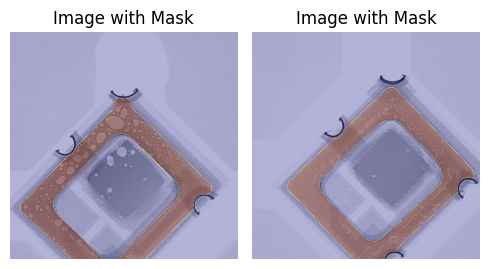

In [ ]:

images, masks = next(iter(train_dl))
#visualize_batch(images=images, masks=masks, num_images=2)

In [ ]:
#| export
def msk_crit(msk):
    return True


In [ ]:
#| export
def create_batch_predictions(
    model: torch.nn.Module,
    image_path: str,
    output_path: str,
    failed_output_path: str,
    batch_size: int = 32,
    input_size: tuple = (128, 128),
    device: str = 'cuda',
    validation: bool = True,
    threshold: float = 0.5,
    overlay_save_path: str = None,
	mask_criteria:str = None, # a string that is a function name in the global scope
    post_process_func: Optional[Callable[[np.ndarray], np.ndarray]] = None,
	num_workers:int = 4,
	test_transform:Callable = None
):
    """
    Create batch-wise prediction masks from a PyTorch model and save them in a folder.
    
    Args:
    model (torch.nn.Module): The PyTorch model for segmentation
    image_dir (str): Path to the directory containing input images
    output_dir (str): Path to the directory where predicted masks that fulfill criteria will be saved
    failed_output_dir (str): Path to the directory where predicted masks that do not fulfill criteria will be saved
    batch_size (int): Batch size for processing
    input_size (tuple): Size to which images will be resized
    device (str): Device to run the model on ('cuda' or 'cpu')
    validation (bool): Whether to shuffle the dataset or not
    threshold (float): Threshold for converting mask probabilities to binary mask
    overlay_save_path (str): Path to save overlay images
    post_process_func (Optional[Callable[[np.ndarray], np.ndarray]]): Function to apply post-processing to the mask
    """

    if output_path is None:
        output_path = Path(Path(image_path).parent, f'masks_{Path(image_path).name}')
    if failed_output_path is None:
        failed_output_path = Path(Path(image_path).parent, f'masks_failed_{Path(image_path).name}')
    else: failed_output_path = Path(failed_output_path)
    if overlay_save_path is None:
        overlay_save_path = Path(Path(image_path).parent, 'masks_overlay')
    else: overlay_save_path = Path(overlay_save_path)
    output_path = Path(output_path)
    output_path.mkdir(parents=True, exist_ok=True)
    failed_output_path = Path(failed_output_path)
    failed_output_path.mkdir(parents=True, exist_ok=True)
    overlay_save_path = Path(overlay_save_path)
    overlay_save_path.mkdir(parents=True, exist_ok=True)
    
    #test_transform = A.Compose([
        #A.Resize(height=input_size[0], width=input_size[1]),
        #ToTensorV2(),
    #])
    
    dataset = InferenceDataset(image_dir=image_path, transform=test_transform)
    if num_workers > 0:
	    dataloader = DataLoader(
               dataset, 
               batch_size=batch_size, 
               shuffle=not validation, 
               num_workers=num_workers, 
               pin_memory=True, 
               persistent_workers=True, 
               prefetch_factor=2)
    else:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=not validation)
    
    model.to(device)
    model.eval()
    
    mask_statistics = []
    
    with torch.no_grad():
        for batch_images, batch_filenames in tqdm(dataloader, desc="Processing Batches"):
            batch_images = batch_images.to(device)
            batch_masks = model(batch_images)
            
            batch_masks = (batch_masks > threshold).float()
            
            for mask, filename in zip(batch_masks, batch_filenames):
                mask = mask.cpu().numpy().squeeze(0)
                mask = (mask * 255).astype(np.uint8)
                
                if post_process_func is not None:
                    mask = post_process_func(mask)
                
                mask_image = Image.fromarray(mask)
                
                mask_crit = globals()[mask_criteria]
                if mask_crit(mask):
                    mask_image.save(Path(output_path, filename))
                    mask_save_path = Path(output_path, filename)
                else:
                    mask_image.save(Path(failed_output_path, filename))
                    mask_save_path = Path(failed_output_path, filename)
                
                if overlay_save_path:
                    Path(overlay_save_path).mkdir(parents=True, exist_ok=True)
                    overlay_mask_border_on_image(
                        im_path=Path(image_path, filename),
                        msk_path=mask_save_path,
                        save_overlay_img_path=overlay_save_path,
                        scale_=2,
                        border_width=1,
                        border_color=(0, 1, 0)
                    )

                mask_statistics.append(create_mask_statistics(mask, filename))

    # Create DataFrame and save to CSV
    df = pd.DataFrame(mask_statistics)
    csv_path = Path(Path(output_path).parent) / 'mask_statistics.csv'
    df.to_csv(csv_path, index=False)

    print(f"Predicted masks saved in {output_path} and {failed_output_path}")
    print(f"Mask statistics saved in {csv_path}")


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export('09_dataset_creation.ipynb')